## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)
*   `n_epochs` de entrenamiento usadas.


El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [58]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import joblib
import pickle
import torchsummary

#### configuramos el `device` acorde al device disponible




In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

1. Cargar base de datos

In [40]:
train_data = pickle.load(open("train.pkl", "rb"))
train_label = pickle.load(open("train_label.pkl", "rb"))
test_data = pickle.load(open("test.pkl", "rb"))
test_label = pickle.load(open("test_label.pkl", "rb"))
val_data = pickle.load(open("val.pkl", "rb"))
val_label = pickle.load(open("val_label.pkl", "rb"))

In [41]:
train_data.shape, train_label.shape

((56000, 28, 28), (56000,))

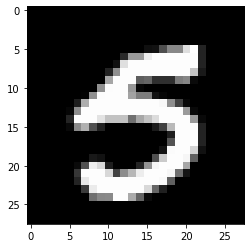

Label: 5


In [45]:
# ploteo esa imagen
plt.imshow(train_data[1], cmap="gray")
plt.show()
print(f"Label: {train_label[1]}")

In [42]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, label, transform=None):
        # TODO
        # 1. Initialize file paths or a list of file names. 
        self.data = data
        self.label = label
        self.transform = transform
        return
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        if torch.is_tensor(index):
            index = index.tolist()
        
        if self.transform:
          return self.transform(self.data[index]), self.label[index]
        else:
          return self.data[index], self.label[index]

    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.data)

In [50]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    # torchvision.transforms.Normalize((0.1307,), (0.3081,))
                  ])

train_dataset = CustomDataset(train_data, train_label, transform=data_transforms)
test_dataset = CustomDataset(test_data, test_label, transform=data_transforms)
valid_dataset = CustomDataset(val_data, val_label, transform=data_transforms)

In [48]:
print(np.shape(train_dataset[0][0]))

torch.Size([1, 28, 28])


In [51]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)

2. Ver que la base de datos esté OK

In [53]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


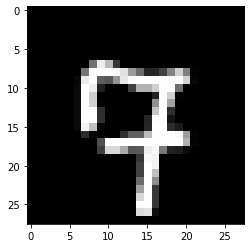

Label: 7


In [54]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(train_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

3. Construyo mi CNN

In [97]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding='valid')
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding='valid')
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1, padding='valid')
        self.fc1 = torch.nn.Linear(in_features=480, out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84, out_features=10)

        print('Red creada')
        print('arquitectura:')
        print(self)
        # Me fijo en el número de capas
        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
        
        # Me fijo en el número de parámetros entrenables
        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)


    def forward(self, x):
        x = self.pool1(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x



In [98]:
model = ConvModel()
if torch.cuda.is_available():
    model.to("cuda")

Red creada
arquitectura:
ConvModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=480, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  7
Número total de parámetros a entrenar:  61226


In [100]:
torchsummary.summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         AvgPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         AvgPool2d-4             [-1, 16, 4, 4]               0
            Conv2d-5            [-1, 120, 2, 2]          17,400
            Linear-6                   [-1, 84]          40,404
            Linear-7                   [-1, 10]             850
Total params: 61,226
Trainable params: 61,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.23
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [101]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, train_loader, valid_loader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(train_loader)
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(valid_loader)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [102]:
fit(model, train_loader, valid_loader, epochs=10)

val_loss 0.36863 val_acc 0.89655: 100%|██████████| 219/219 [00:01<00:00, 184.51it/s]


Epoch 1/10 loss 0.72358 val_loss 0.36863 acc 0.80304 val_acc 0.89655


val_loss 0.26014 val_acc 0.92337: 100%|██████████| 219/219 [00:01<00:00, 135.10it/s]


Epoch 2/10 loss 0.32417 val_loss 0.26014 acc 0.90523 val_acc 0.92337


val_loss 0.20218 val_acc 0.94007: 100%|██████████| 219/219 [00:01<00:00, 173.84it/s]


Epoch 3/10 loss 0.24240 val_loss 0.20218 acc 0.92825 val_acc 0.94007


val_loss 0.16503 val_acc 0.95020: 100%|██████████| 219/219 [00:01<00:00, 179.00it/s]


Epoch 4/10 loss 0.19390 val_loss 0.16503 acc 0.94263 val_acc 0.95020


val_loss 0.14179 val_acc 0.95805: 100%|██████████| 219/219 [00:01<00:00, 180.52it/s]


Epoch 5/10 loss 0.16039 val_loss 0.14179 acc 0.95237 val_acc 0.95805


val_loss 0.12427 val_acc 0.96123: 100%|██████████| 219/219 [00:01<00:00, 175.57it/s]


Epoch 6/10 loss 0.13637 val_loss 0.12427 acc 0.95913 val_acc 0.96123


val_loss 0.10782 val_acc 0.96656: 100%|██████████| 219/219 [00:01<00:00, 174.93it/s]


Epoch 7/10 loss 0.11785 val_loss 0.10782 acc 0.96443 val_acc 0.96656


val_loss 0.09597 val_acc 0.97141: 100%|██████████| 219/219 [00:01<00:00, 177.20it/s]


Epoch 8/10 loss 0.10339 val_loss 0.09597 acc 0.96948 val_acc 0.97141


val_loss 0.08663 val_acc 0.97517: 100%|██████████| 219/219 [00:01<00:00, 178.58it/s]


Epoch 9/10 loss 0.09133 val_loss 0.08663 acc 0.97291 val_acc 0.97517


val_loss 0.08094 val_acc 0.97465: 100%|██████████| 219/219 [00:01<00:00, 178.81it/s]

Epoch 10/10 loss 0.08177 val_loss 0.08094 acc 0.97629 val_acc 0.97465


In [103]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

criterion = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy()
if torch.cuda.is_available():
  accuracy.to("cuda")

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = model(test_data)
  test_loss += criterion(output, test_target).item()
  test_accuracy += accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.079859 y una accuracy de 0.975885


torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


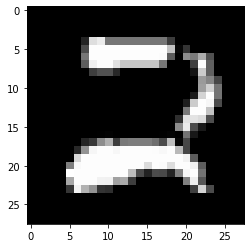

torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[ 1.5980, -0.6573,  9.8145,  2.3356, -5.3434, -2.2516, -0.2909, -2.2286,
          0.1393, -3.9329]], device='cuda:0', grad_fn=<AddmmBackward0>)
softmax de predicción:
tensor([[2.6991e-04, 2.8296e-05, 9.9902e-01, 5.6432e-04, 2.6096e-07, 5.7459e-06,
         4.0818e-05, 5.8796e-06, 6.2765e-05, 1.0694e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
El numero es un:  2


In [108]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(test_loader))

# item a usar k
k = 10

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))
# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print(samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat)
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1))
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

# score final

In [112]:
test_acc = 0.975885
n_params = 61226
n_layers = 7
n_epochs = 10

score = 1/np.log10(n_params) * 10/n_epochs * test_acc * n_layers
print(f'Score {score}:')

Score 1.4270496119090854:
